In [1]:
import numpy as np
from scipy.integrate import ode

from matplotlib import pyplot as plt


We define the membrane equation :

$\tau_m \frac{d}{dt} V(t) = E_L- V(t) + R I(t) $ if $V(t) \leq V_{th}$

$V(t) = V_{reset}$ + record a spike otherwise




In [2]:
#Parameters of the equation with the corresponding units 

t_max = 150e-3   # second
dt = 1e-3        # second

tau_m = 20e-3      # second
E_l = -60e-3      # milivolt

V_reset = -70e-3      # milivolt
V_th = -50e-3     # milivolt
R = 100e6        # ohm
I_mean = 25e-11  # ampere


#Different ansatz for the synaptic current 

def I_sin(t, I_mean, Delta = 0.01):
    return I_mean*(1+np.sin(2*np.pi/Delta*t))


def I_rand(I_mean, tmax, dt, Delta = 0.1):
    return I_mean*(1+ Delta*np.sqrt(tmax/dt) * (2*np.random.rand() -1) )



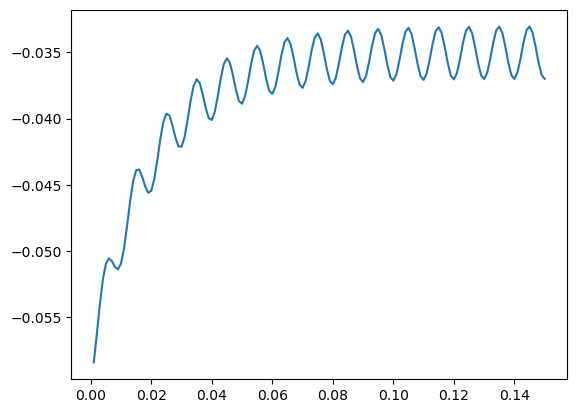

In [3]:
# Membrane equation : deterministic synaptic input 

def rhs(t, V, tau_m, E_l, R, I, I_mean):
    return 1/tau_m*(E_l - V + R*I(t,I_mean))
                   
                   
res = ode(rhs).set_integrator('zvode', method='bdf')
res.set_f_params(tau_m, E_l, R, I_sin, I_mean)
res.set_initial_value(E_l, 0)

t_list = []
Vt = []

while res.successful() and res.t < t_max:
    t_list.append(res.t+dt)
    Vt.append(np.real(res.integrate(res.t+dt)) )
    
    
plt.plot(t_list, Vt)

In [4]:
# Membrane potential : random synaptic input 

n_reals = 500

def rhs(t, V, tau_m, E_l, R, I):
    return 1/tau_m*(E_l - V + R*I)
                   
res = ode(rhs).set_integrator('zvode', method='bdf')

Vt_j = np.zeros((n_reals, int(t_max/dt)))


for p in range(n_reals):
    t=0
    res.set_initial_value(E_l, 0)
    t_list = []
    while res.successful() and res.t < t_max:
        It = I_rand(I_mean, t_max, dt)
        res.set_f_params(tau_m, E_l, R, It)
        t_list.append(res.t+dt)
        Vt_j[p,t] = np.real(res.integrate(res.t+dt)[0])
        t = t+1

        
V_mean = 1/n_reals*np.einsum('ij->j', Vt_j)

for j in range(n_reals):
    plt.plot(t_list, Vt_j[j], 'k', alpha=0.1)
    
    
plt.plot(t_list, V_mean, 'o', markersize = 1.5, label = 'Mean')
plt.legend()
plt.title('Membrane potential following a random synaptic input, '+str(n_reals)+' realizations')
plt.xlabel('t (sec)')
plt.ylabel('V(t)')


KeyboardInterrupt: 

(array([ 3.,  3.,  1.,  1.,  4.,  3.,  5.,  8.,  6.,  7.,  9., 15., 13.,
        19., 12., 21., 19., 26., 26., 15., 15., 14., 25., 12., 21., 25.,
        13., 18., 19., 15., 20., 10., 10.,  9., 12.,  7.,  4.,  7.,  5.,
         8.,  2.,  3.,  1.,  5.,  1.,  0.,  1.,  1.,  0.,  1.]),
 array([-0.04169086, -0.04139371, -0.04109655, -0.0407994 , -0.04050224,
        -0.04020509, -0.03990793, -0.03961078, -0.03931362, -0.03901646,
        -0.03871931, -0.03842215, -0.038125  , -0.03782784, -0.03753069,
        -0.03723353, -0.03693638, -0.03663922, -0.03634207, -0.03604491,
        -0.03574776, -0.0354506 , -0.03515345, -0.03485629, -0.03455914,
        -0.03426198, -0.03396483, -0.03366767, -0.03337052, -0.03307336,
        -0.03277621, -0.03247905, -0.0321819 , -0.03188474, -0.03158759,
        -0.03129043, -0.03099328, -0.03069612, -0.03039897, -0.03010181,
        -0.02980466, -0.0295075 , -0.02921035, -0.02891319, -0.02861604,
        -0.02831888, -0.02802173, -0.02772457, -0.02742742,

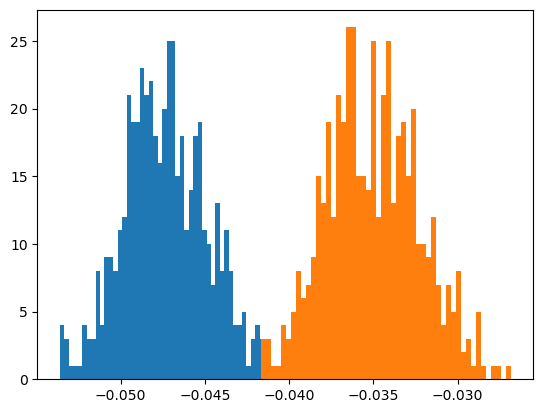

In [5]:
# We also compute the distribution of the potential following a random synaptic input for a fixed time t_k 

t_k = t_max/10
t_k_I = t_max

k = int(np.where(np.round(t_list,4) == t_k)[0])
k_I = int(np.where(np.round(t_list,4) == t_k_I)[0])


Vk = Vt_j[:,k]
Vk_I = Vt_j[:,k_I]


nbins = 50
plt.hist(Vk, nbins)
plt.hist(Vk_I, nbins)


In [1]:
# Here we add the spikes

n_reals = 500

def rhs(t, V, tau_m, E_l, R, I):
    return 1/tau_m*(E_l - V + R*I)
                   
res = ode(rhs).set_integrator('zvode', method='bdf')

Vt_j = np.zeros((n_reals, int(t_max/dt)))


spike_times =  [ [] for j in range(n_reals)]
spike_occurrence = np.zeros(int(t_max/dt))



for p in range(n_reals):
    t=0
    res.set_initial_value(E_l, 0)
    t_list = []
    
    while res.successful() and res.t < t_max:
        It = I_rand(I_mean, t_max, dt)
        res.set_f_params(tau_m, E_l, R, It)
        t_list.append(res.t+dt)
        Vt_j[p,t] = np.real(res.integrate(res.t+dt)[0])

        if Vt_j[p,t] >= V_th : 
            Vt_j[p,t] = V_reset
            spike_occurrence[t] = spike_occurrence[t]+1
            spike_times[p].append(t_list[t])
            res.set_initial_value(V_reset, t_list[t])
        

        t = t+1
        
        
V_mean = 1/n_reals*np.einsum('ij->j', Vt_j)
spike_rate = spike_occurrence/n_reals



# Figures
plt.figure()

# Plot simulations and sample mean
ax1 = plt.subplot(3, 1, 1)
for j in range(n_reals):
    plt.scatter(t_list, Vt_j[j], color="k", marker=".", alpha=0.01)
    plt.plot(t_list, V_mean, 'C1', alpha=0.8, linewidth=3)
    plt.ylabel('$V_m$ (V)')

# Plot spikes
plt.subplot(3, 1, 2, sharex=ax1)
# for each neuron j: collect spike times and plot them at height j
for j in range(n_reals):
    times = np.array(spike_times[j])
    plt.scatter(times, j * np.ones_like(times), color="C0", marker=".", alpha=0.2)


plt.ylabel('neuron')

# Plot firing rate
plt.subplot(3, 1, 3, sharex=ax1)
plt.plot(t_list, spike_rate)
plt.xlabel('time (s)')
plt.ylabel('rate (Hz)')

plt.tight_layout()


NameError: name 'ode' is not defined

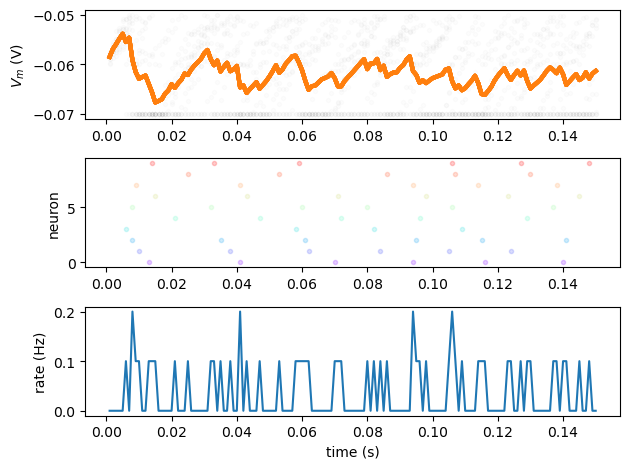

In [6]:
# Here we add the spikes + refractory period

n_reals = 10

def rhs(t, V, tau_m, E_l, R, I):
    return 1/tau_m*(E_l - V + R*I)
                   
res = ode(rhs).set_integrator('zvode', method='bdf')

Vt_j = E_l*np.ones((n_reals, int(t_max/dt)))


spike_times =  [ [] for j in range(n_reals)]
spike_occurrence = np.zeros(int(t_max/dt))

# Initialize t_ref and last_spike
t_ref = 0.01
#last_spike = -t_ref * np.ones([n])





t_list = []
t=0
res.set_initial_value(E_l, dt)


to_iterate = list(range(n_reals))
to_restore = []

while res.successful() and res.t < t_max+dt:
    t_list.append(res.t)
    spike_index=[]
    
    for tt in range(n_reals): #Here we re-introduce the neurons in the loop
        if tt not in to_iterate and t_list[-1] >= spike_times[tt][-1]+t_ref: #If the refractory period is passed
            to_iterate.append(tt)
            to_iterate.sort()

    if len(to_iterate)==0: res.t = res.t+dt #The evolution advances if all the neurons have spiked
    
    else:
        for p in to_iterate:
            res.set_initial_value(Vt_j[p,t-1], t_list[t]) #Initial conditions   
            It = I_rand(I_mean, t_max, dt) #Set the input
            res.set_f_params(tau_m, E_l, R, It) #Set the input
            Vt_j[p,t] = np.real(res.integrate(t_list[t]+dt)[0]) #Solves the differential equation
        
           
            if Vt_j[p,t] >= V_th :  #If p-th neuron spikes
                spike_times[p].append(t_list[t]) 
                spike_occurrence[t] = spike_occurrence[t]+1
                to_iterate.remove(p)
    
    if len(to_iterate) < n_reals: #If some neurons is resting 
        indxs = [k for k in list(range(n_reals)) if k not in to_iterate] #Get the index of the spikes
        Vt_j[indxs,t] = V_reset #Set the potential to the reset value
        res.set_initial_value(V_reset, t_list[t]+dt) #reset the initial conditions

    t = t+1

        
V_mean = 1/n_reals*np.einsum('ij->j', Vt_j)
spike_rate = spike_occurrence/n_reals







# Figures


plt.figure()

# Plot simulations and sample mean
ax1 = plt.subplot(3, 1, 1)
for j in range(n_reals):
    plt.scatter(t_list, Vt_j[j], color="k", marker=".", alpha=0.01)
    plt.plot(t_list, V_mean, 'C1', alpha=0.8, linewidth=3)
    plt.ylabel('$V_m$ (V)')

# Plot spikes
plt.subplot(3, 1, 2, sharex=ax1)
colors = plt.cm.rainbow(np.linspace(0, 1, n_reals))

# for each neuron j: collect spike times and plot them at height j
for j in range(n_reals):
    times = np.array(spike_times[j])
    plt.scatter(times, j * np.ones_like(times), color=colors[j], marker=".", alpha=0.2)


plt.ylabel('neuron')

# Plot firing rate
plt.subplot(3, 1, 3, sharex=ax1)
plt.plot(t_list, spike_rate)
plt.xlabel('time (s)')
plt.ylabel('rate (Hz)')

plt.tight_layout()


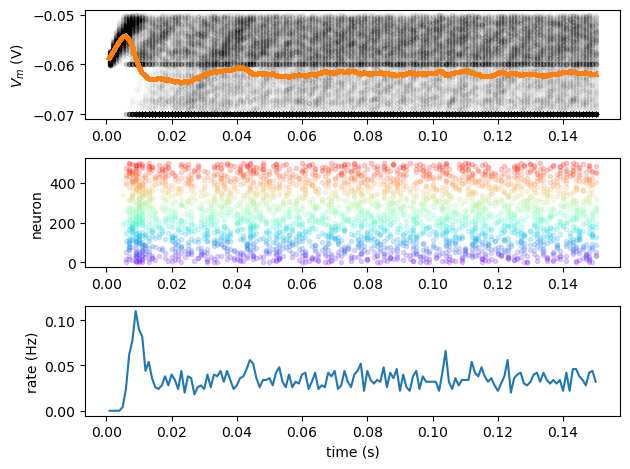

In [20]:
# Here we add the spikes + neuron-dependent normally distributed refractory period

# TO DO : summarize all this into a function 


n_reals = 500

def rhs(t, V, tau_m, E_l, R, I):
    return 1/tau_m*(E_l - V + R*I)
                   
res = ode(rhs).set_integrator('zvode', method='bdf')

Vt_j = E_l*np.ones((n_reals, int(t_max/dt)))


spike_times =  [ [] for j in range(n_reals)]
spike_occurrence = np.zeros(int(t_max/dt))

# Initialize t_ref and last_spike

mu=0.01

sigma=0.007



t_ref = mu + sigma*np.random.normal(size=n_reals)




t_list = []
t=0
res.set_initial_value(E_l, dt)


to_iterate = list(range(n_reals))
to_restore = []

while res.successful() and res.t < t_max+dt:
    t_list.append(res.t)
    spike_index=[]
    
    for tt in range(n_reals): #Here we re-introduce the neurons in the loop
        if tt not in to_iterate and t_list[-1] >= spike_times[tt][-1]+t_ref[tt]: #If the refractory period is passed
            to_iterate.append(tt)
            to_iterate.sort()

    if len(to_iterate)==0: res.t = res.t+dt #The evolution advances if all the neurons have spiked
    
    else:
        for p in to_iterate:
            res.set_initial_value(Vt_j[p,t-1], t_list[t]) #Initial conditions   
            It = I_rand(I_mean, t_max, dt) #Set the input
            res.set_f_params(tau_m, E_l, R, It) #Set the input
            Vt_j[p,t] = np.real(res.integrate(t_list[t]+dt)[0]) #Solves the differential equation
        
           
            if Vt_j[p,t] >= V_th :  #If p-th neuron spikes
                spike_times[p].append(t_list[t]) 
                spike_occurrence[t] = spike_occurrence[t]+1
                to_iterate.remove(p)
    
    if len(to_iterate) < n_reals: #If some neurons is resting 
        indxs = [k for k in list(range(n_reals)) if k not in to_iterate] #Get the index of the spikes
        Vt_j[indxs,t] = V_reset #Set the potential to the reset value
        res.set_initial_value(V_reset, t_list[t]+dt) #reset the initial conditions

    t = t+1

        
V_mean = 1/n_reals*np.einsum('ij->j', Vt_j)
spike_rate = spike_occurrence/n_reals







# Figures


plt.figure()

# Plot simulations and sample mean
ax1 = plt.subplot(3, 1, 1)
for j in range(n_reals):
    plt.scatter(t_list, Vt_j[j], color="k", marker=".", alpha=0.01)
    plt.plot(t_list, V_mean, 'C1', alpha=0.8, linewidth=3)
    plt.ylabel('$V_m$ (V)')

# Plot spikes
plt.subplot(3, 1, 2, sharex=ax1)
colors = plt.cm.rainbow(np.linspace(0, 1, n_reals))

# for each neuron j: collect spike times and plot them at height j
for j in range(n_reals):
    times = np.array(spike_times[j])
    plt.scatter(times, j * np.ones_like(times), color=colors[j], marker=".", alpha=0.2)


plt.ylabel('neuron')

# Plot firing rate
plt.subplot(3, 1, 3, sharex=ax1)
plt.plot(t_list, spike_rate)
plt.xlabel('time (s)')
plt.ylabel('rate (Hz)')

plt.tight_layout()
